In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

# !git config --global user.email 'intaek428@gmail.com'
# !git config --global user.name 'ITHwang'

# !git add .
# !git commit -m ''
# !git push

!pip install -Uqq fastbook

In [ ]:
from fastai.vision.all import *

In [ ]:
top_edge = tensor([[-1, -1, -1],
                   [0, 0, 0],
                   [1, 1, 1]]).float()

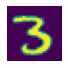

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

im3 = Image.open(path/'train'/'3'/'12.png')
show_image(im3)

In [ ]:
im3_t = tensor(im3)
im3_t

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,  12,  99,  91, 142, 155, 246, 182, 155, 155, 155, 155,
         131,  52,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 138, 254, 254, 254, 25

In [ ]:
df = pd.DataFrame(im3_t[:10, :20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [ ]:
(im3_t[4:7, 6:9] * top_edge).sum()

tensor(762.)

In [ ]:
def apply_kernel(row, col, kernel):
    return (im3_t[row-1:row+2, col-1:col+2] * kernel).sum()
apply_kernel(5, 7, top_edge)

tensor(762.)

In [ ]:
[[(i, j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

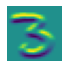

In [ ]:
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])
show_image(top_edge3)

In [ ]:
left_edge = tensor([[-1, 1, 0],
                    [-1, 1, 0],
                    [-1, 1, 0]])
left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])

In [ ]:
diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]]).float()

diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0, 1]]).float()

In [ ]:
edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [ ]:
mnist = DataBlock((ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)
dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
xb, yb = to_cpu(xb), to_cpu(yb)

In [ ]:
edge_kernels.unsqueeze(1).shape

torch.Size([4, 1, 3, 3])

In [ ]:
edge_kernels = edge_kernels.unsqueeze(1)
batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

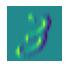

In [ ]:
show_image(batch_features[0, 0])

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)

In [ ]:
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [ ]:
simple_cnn = sequential(
    conv(1, 4), # 14 x 14
    conv(4, 8), # 7 x 7
    conv(8, 16), # 4 x 4
    conv(16, 32), # 2 x 2
    conv(32, 2, act=False),
    Flatten(),
)

In [ ]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)
learn.summary()

Sequential (Input shape: 64 x 1 x 28 x 28)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 4 x 14 x 14    
Conv2d                                    40         True      
ReLU                                                           
____________________________________________________________________________
                     64 x 8 x 7 x 7      
Conv2d                                    296        True      
ReLU                                                           
____________________________________________________________________________
                     64 x 16 x 4 x 4     
Conv2d                                    1168       True      
ReLU                                                           
____________________________________________________________________________
                     64 x 32 x 2 x 2     
Conv2d                                    4640       True      
ReLU                                          

In [ ]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.063672,0.031847,0.988224,00:18
1,0.020290,0.017171,0.993131,00:18


In [ ]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [ ]:
def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items=get_image_files,
        splitter=GrandparentSplitter('training', 'testing'),
        get_y=parent_label,
        batch_tfms=Normalize()
    ).dataloaders(path, bs=bs)

dls = get_dls()

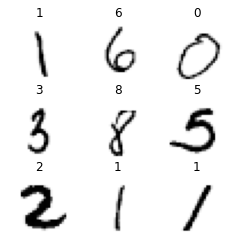

In [ ]:
dls.show_batch(max_n=9, figsize=(4,4))

In [ ]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [ ]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),
        conv(8, 16),
        conv(16, 32),
        conv(32, 64),
        conv(64, 10, act=False),
        Flatten()
    )

In [ ]:
from fastai.callback.hook import *

In [ ]:
def fit(epochs=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epochs, 0.06)
    return learn
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,2.307581,2.307331,0.113500,01:36


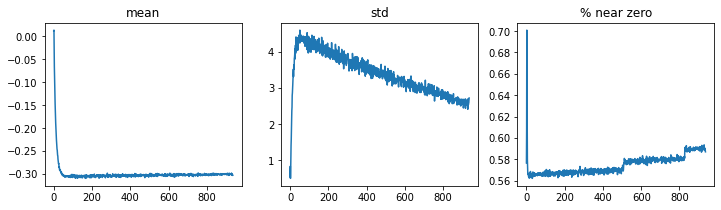

In [ ]:
learn.activation_stats.plot_layer_stats(0)

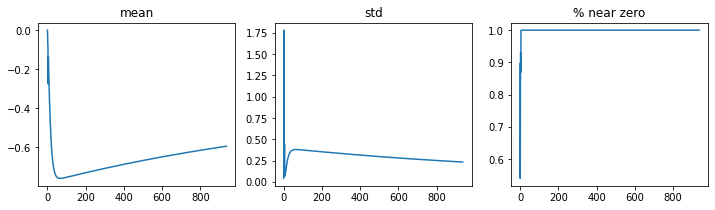

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
def fit(epochs=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epochs, lr)
    return learn

learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.183657,0.156273,0.953800,01:34


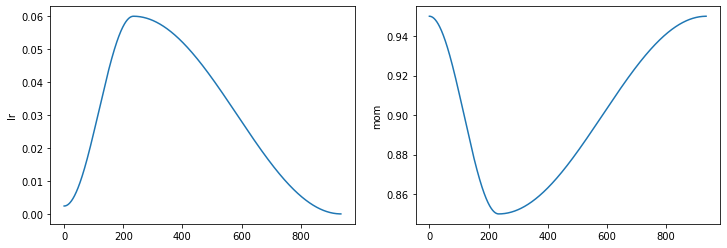

In [ ]:
learn.recorder.plot_sched()

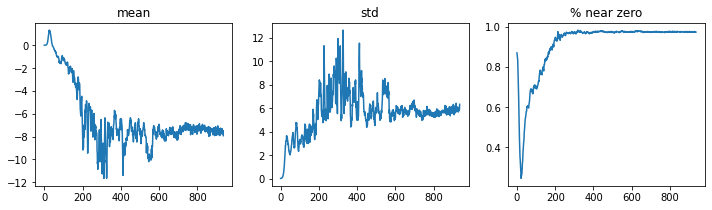

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

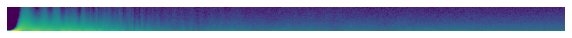

In [ ]:
learn.activation_stats.color_dim(-2)

In [ ]:
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [ ]:
learn = fit()

/usr/local/lib/python3.7/dist-packages/fastai/callback/core.py:51: UserWarning: You are shadowing an attribute (modules) that exists in the learner. Use `self.learn.modules` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


epoch,train_loss,valid_loss,accuracy,time
0,0.055523,0.039233,0.988000,01:48


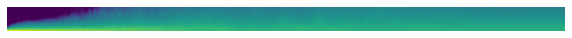

In [ ]:
learn.activation_stats.color_dim(-4)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/fastai-practice

!git config --global user.email 'intaek428@gmail.com'
!git config --global user.name 'ITHwang'

!git add .
!git commit -m 'chap13 끝'
!git push

/content/drive/MyDrive/Colab Notebooks/fastai-practice


In [ ]:
def block(ni, nf): return ConvLayer(ni, nf, stride=2)
def get_model():
    return nn.Sequential(
        block(3, 16),
        block(16, 32),
        block(32, 64),
        block(64, 128),
        block(128, 256),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c)
    )